In [1]:
import os
import json
import re
from collections import defaultdict, Counter
from tqdm import tqdm
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import defaultdict, Counter

In [2]:
SPLIT_PATTERN = re.compile(r'\s*[,/;]+\s*|\s+and\s+')

def parse_occupations(line):
    """Unified occupation parsing used by both functions"""
    occupations = set()
    tokens = line.split('\t')
    for token in tokens:
        if 'occupation_' in token:
            part = token.split(':', 1)[1].strip()
            part = part.replace('[[', '').replace(']]', '').replace('*', '').strip()
            if part:
                # Split using shared pattern and normalize
                split_parts = SPLIT_PATTERN.split(part)
                for p in split_parts:
                    clean = p.strip().lower()
                    if clean:
                        occupations.add(clean)
    return occupations
# ==========================================================

def count_occupations(dataset_dir):
    counter = Counter()
    subsets = ['train/train', 'valid/valid', 'test/test']
    
    for subset in subsets:
        box_file = os.path.join(dataset_dir, f"{subset}.box")
        with open(box_file, 'r', encoding='utf-8') as bfile:
            for line in tqdm(bfile, desc=f"Counting {subset}"):
                occupations = parse_occupations(line)
                counter.update(occupations)
    
    return counter

def get_groups(dataset_dir, target_occupations, char_threshold=50):
    groups = {occ: defaultdict(str) for occ in target_occupations}
    subsets = ['train/train', 'valid/valid', 'test/test']

    for subset in subsets:
        title_file = os.path.join(dataset_dir, f"{subset}.title")
        box_file = os.path.join(dataset_dir, f"{subset}.box")
        sent_file = os.path.join(dataset_dir, f"{subset}.sent")
        nb_file = os.path.join(dataset_dir, f"{subset}.nb")

        with open(title_file, 'r') as tfile, \
             open(box_file, 'r') as bfile, \
             open(sent_file, 'r') as sfile, \
             open(nb_file, 'r') as nfile:

            titles = [line.strip() for line in tfile]
            sents = [line.strip() for line in sfile]
            nb_counts = [int(line.strip()) for line in nfile]
            
            sent_ptr = 0
            for idx, (bline, num_sent) in enumerate(zip(bfile, nb_counts)):
                occupations = parse_occupations(bline)
                summary = ' '.join(sents[sent_ptr:sent_ptr + num_sent]).strip()
                name = titles[idx]
                
                if len(summary) >= char_threshold:
                    for occ in occupations & set(target_occupations):
                        groups[occ][name] = summary
                
                sent_ptr += num_sent

    return groups

In [3]:
dataset_dir = 'wikipedia-biography-dataset/wikipedia-biography-dataset'

# Get counts
counts = count_occupations(dataset_dir)
sorted_occupations = sorted(counts.items(), key=lambda x: (-x[1], x[0]))
top_ten = [occ for occ, _ in counts.most_common(10)]

Counting train/train: 3588it [00:00, 35872.85it/s]

Counting train/train: 582659it [00:05, 98916.15it/s] 
Counting valid/valid: 72831it [00:00, 83292.33it/s]
Counting test/test: 72831it [00:00, 93282.44it/s] 


In [4]:
with open('output/top_ten/occupation_counts_2.json', 'w', encoding='utf-8') as f:
    json.dump(sorted_occupations, f, ensure_ascii=False, indent=2)

In [2]:
top_ten = ["actor", "actress", "singer", "producer", "musician", "director", "writer", "songwriter", "politician", "author"]

In [6]:
# Get groups
groups = get_groups(dataset_dir, top_ten, char_threshold=50)

for o in groups:
    print(f"{o}: {len(groups[o])} biographies")

actor: 27071 biographies
actress: 19860 biographies
singer: 16337 biographies
producer: 15776 biographies
musician: 14879 biographies
director: 14402 biographies
writer: 14102 biographies
songwriter: 9870 biographies
politician: 8517 biographies
author: 8081 biographies


In [7]:
with open("output/top_ten/occupation_summaries.json", "w") as f:
    json.dump(groups, f, indent=2, ensure_ascii=False)

In [3]:
with open("output/top_ten/occupation_summaries.json", "r", encoding="utf-8") as f:
    groups = json.load(f)

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/yc833/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yc833/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yc833/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from utils import preprocess_text, get_feature_probabilities

[nltk_data] Downloading package stopwords to /home/yc833/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yc833/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yc833/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
from utils import save_feature_probs, save_all_matrices

In [7]:
feature_probs, all_matrices = get_feature_probabilities(groups)
save_feature_probs(feature_probs, "output/top_ten/feature_probabilities_wiki_2.json")
save_all_matrices(all_matrices, "output/top_ten/all_matrices_wiki_2.json")

Processing occupations:   0%|          | 0/10 [00:00<?, ?it/s]

Processing occupations: 100%|██████████| 10/10 [04:49<00:00, 28.99s/it]


In [29]:
feature_probs.keys()

dict_keys(['actor', 'actress', 'singer', 'producer', 'musician', 'director', 'writer', 'songwriter', 'politician', 'author'])

In [8]:
from utils import plot_heatmap

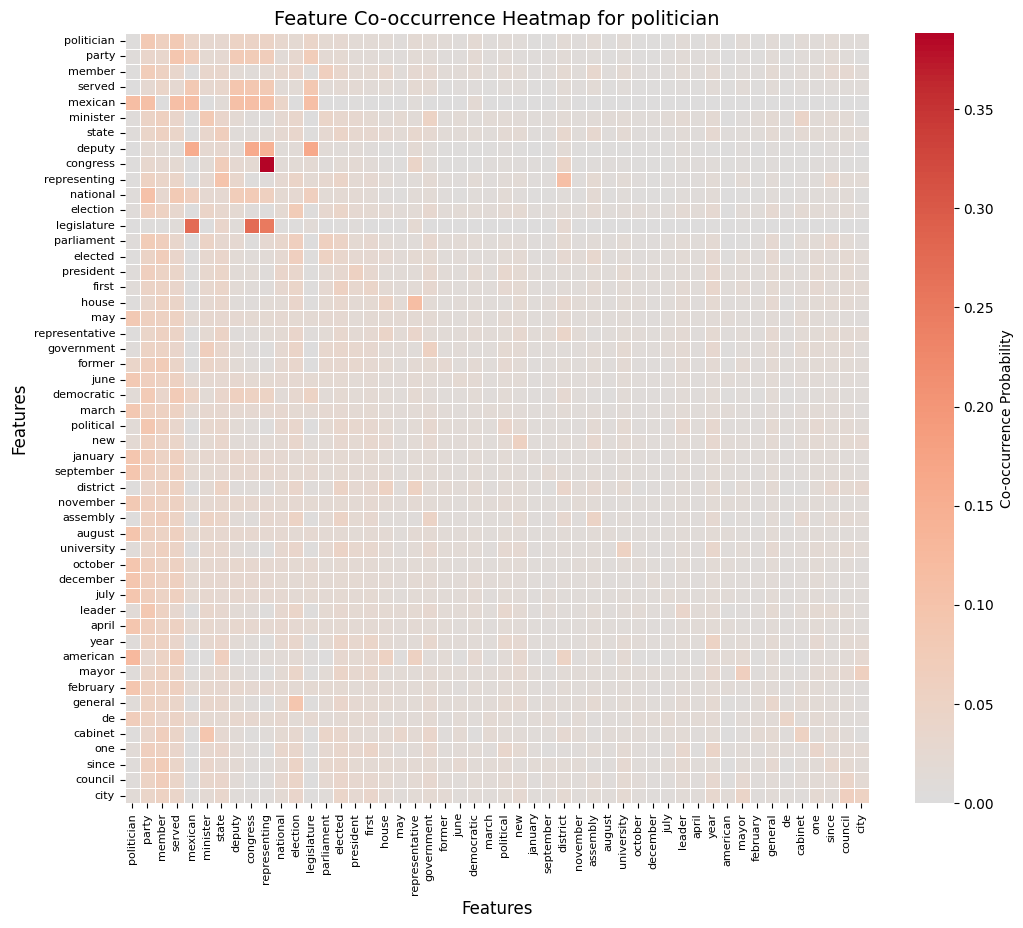

In [9]:
occupation = 'politician'
data_for_occupation = all_matrices[occupation] 
plot_heatmap(data_for_occupation, occupation)

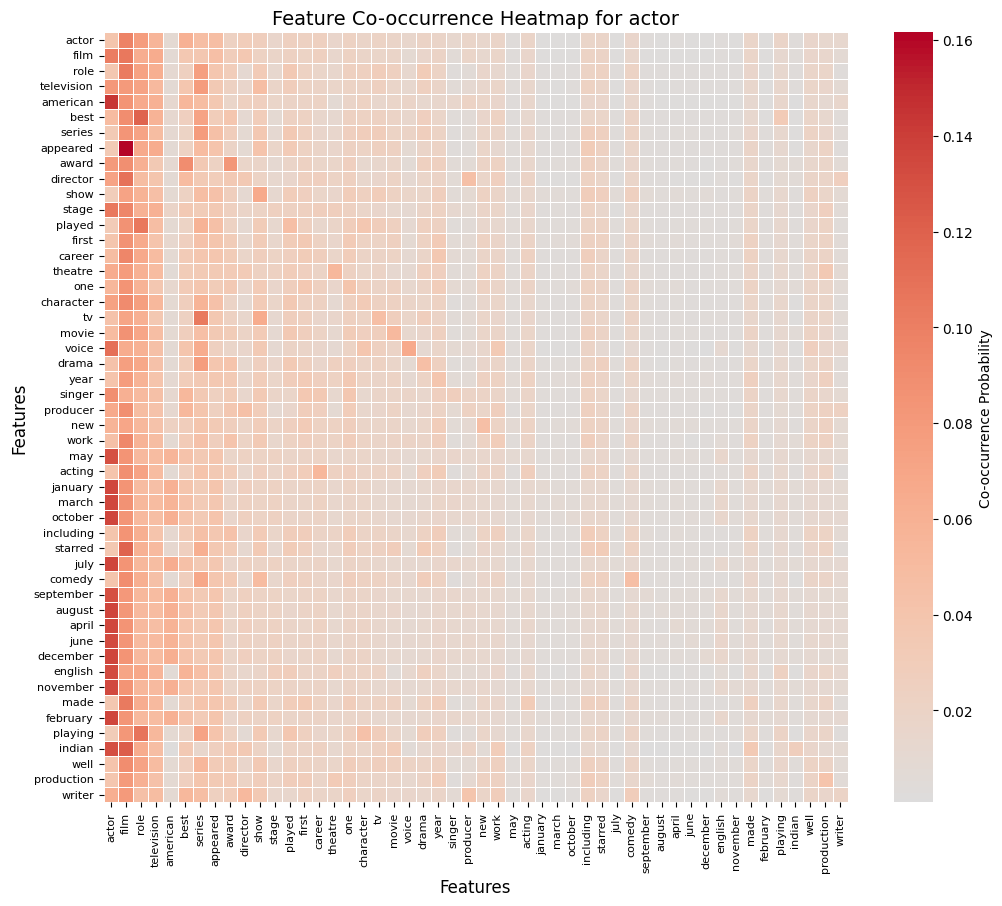

In [11]:
occupation = 'actor'
data_for_occupation = all_matrices[occupation] 
plot_heatmap(data_for_occupation, occupation)

In [ ]:
# import utils
# print(dir(utils))  


['Counter', 'WordNetLemmatizer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'build_probability_matrix_from_list', 'defaultdict', 'get_feature_probabilities', 'json', 'nltk', 'np', 'os', 'preprocess_text', 'save_outputs', 'save_sorted_probabilities', 'stopwords', 'tqdm', 'word_tokenize']


In [10]:
all_matrices["politician"]["matrix"].sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])